## NEP_Order_parameter

In [1]:
from ase.io import read
from ase.neighborlist import neighbor_list
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots

plt.style.use(['science','ieee','no-latex','bright'])

def calculate_order_parameter(atoms, central_element='Ge', neighboring_element='Te'):
    cell = atoms.get_cell()
    distances = atoms.get_all_distances(mic=True)
    positions = atoms.get_positions()
    
    i_list, j_list = neighbor_list('ij', atoms, 4)
    central_atoms = [i for i, element in enumerate(atoms.get_chemical_symbols()) if element == central_element]
    neighboring_atoms = [i for i, element in enumerate(atoms.get_chemical_symbols()) if element == neighboring_element]
    
    polarization_vectors = []
    for central_atom in central_atoms:
        neighbors = [(j_list[k], distances[central_atom, j_list[k]]) for k in range(len(i_list)) if i_list[k] == central_atom and j_list[k] in neighboring_atoms]
        neighbors = sorted(neighbors, key=lambda x: x[1])[:6]
        nearest_neighbors = [index for index, _ in neighbors]
        central_position = positions[central_atom]
        neighbor_positions = positions[nearest_neighbors]
        displacements = neighbor_positions - central_position
        displacements -= np.round(displacements @ np.linalg.inv(cell)) @ cell
        neighbor_positions = central_position + displacements
        center_of_mass = np.mean(neighbor_positions, axis=0)
        polarization_vector = central_position - center_of_mass
        polarization_vectors.append(polarization_vector)
    tau = np.sum(polarization_vectors, axis=0)
    
    return tau / len(central_atoms), np.linalg.norm(tau) / len(central_atoms)

def func(T, A, T_C, alpha):
    return A * (T_C - T) ** alpha

def plot_and_fit(data, x_label, y_label, label):
    T_data = np.array(data["temp"])[:10]
    f_data = np.array(data[y_label])[:10]
    
    initial_guess = [0.05, 500, 0.3]
    popt, pcov = curve_fit(func, T_data, f_data, p0=initial_guess)
    A, T_C, alpha = popt
    
    print(f"拟合得到的 {label} 的 A 值:", A)
    print(f"拟合得到的 {label} 的 T_C 值:", T_C)
    print(f"拟合得到的 {label} 的 α 值:", alpha)
    
    T_fit = np.linspace(min(T_data)-50, max(T_data), 500)
    f_fit = func(T_fit, *popt)
    plt.plot(T_fit, f_fit, '--', label=f'Fit {label}')

In [ ]:
import time
start = time.time()

frames = read('../split_xyz_files/split_800.xyz', index=':')
tau_list = []
norm_tau_list = []
for i in range(len(frames)):
    tau, norm_tau = calculate_order_parameter(frames[i])
    tau_list.append(tau)
    norm_tau_list.append(norm_tau)
    
tau_average = np.linalg.norm(np.mean(tau_list, axis=0))
tau_average_abs = np.mean(norm_tau_list)

end = time.time()
print("运行时间："+str((end-start)/60)+"分钟")

tau_average, tau_average_abs

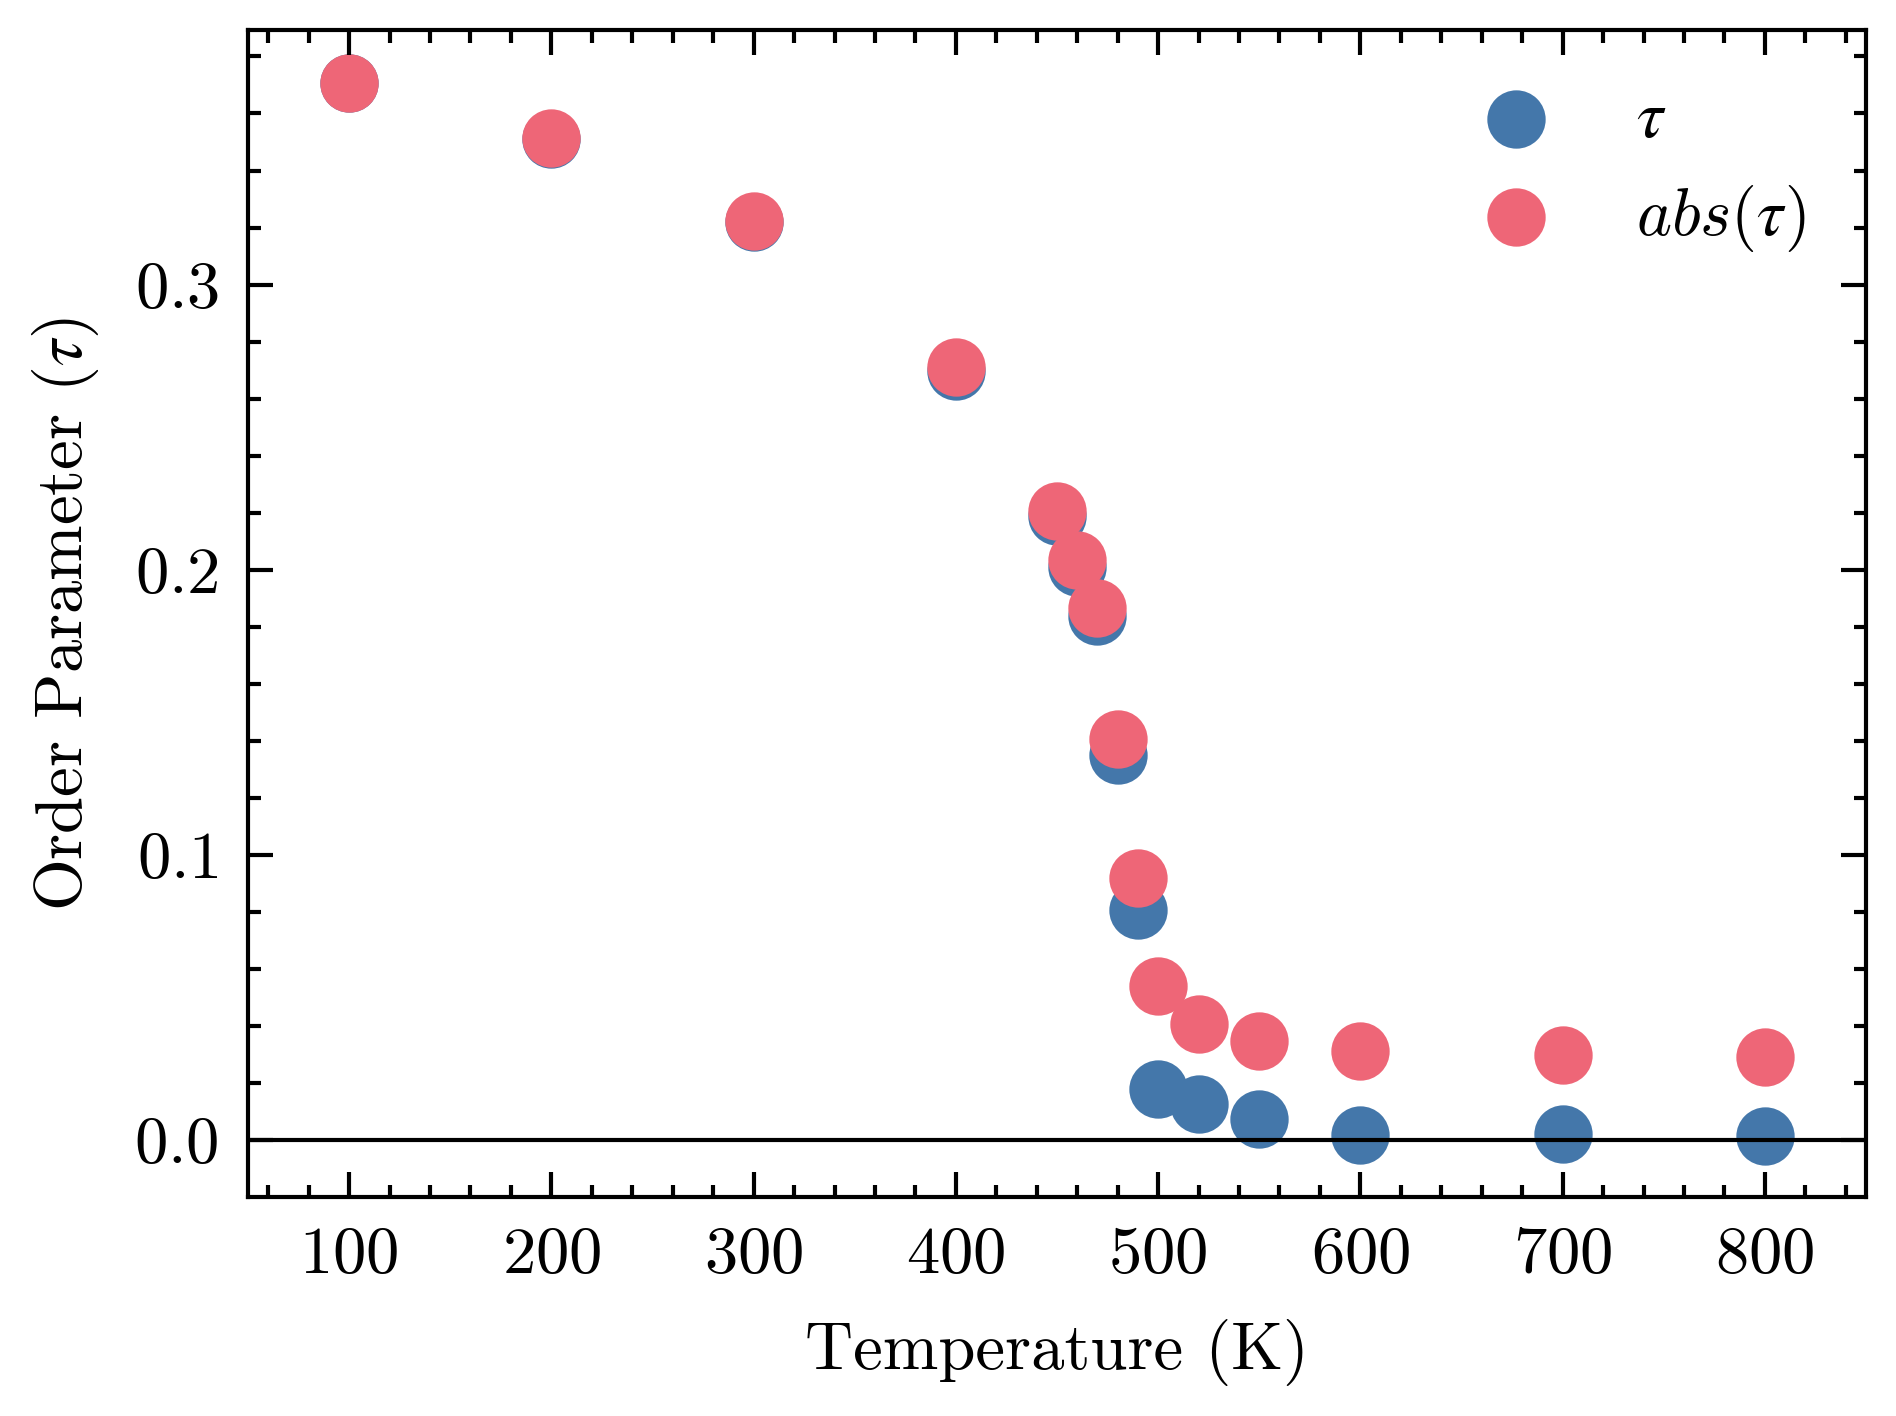

In [2]:
data = [[100, 0.3707234232617653, 0.3708104708893618],
        [200, 0.3511269080417099, 0.3513631308088041],
        [300, 0.32196992730776525, 0.32242138484534194],
        [400, 0.2697722867316692, 0.27100003212625023],
        [450, 0.2189616207691809, 0.22067675764495986],
        [460, 0.20101872089748654, 0.20325749775241958],
        [470, 0.18369301591400017, 0.18652031958222637],
        [480, 0.1351353043396572, 0.14055082244088307],
        [490, 0.08072467191111543, 0.09194228098892163],
        [500, 0.017715155442809053, 0.05383819623619727],
        [520, 0.01246450516227039, 0.04051036611208163],
        [550, 0.007385004672354357, 0.03476066780312333],
        [600, 0.001818636401012265, 0.03102460511958047],
        [700, 0.002103218770323888, 0.029825479041382545],
        [800, 0.0013567352150027647, 0.02895128835228921]]
df = pd.DataFrame(data, columns=["temp", "average", "abs"])

plt.figure()
plt.scatter(df["temp"], df["average"], marker='o', label="$τ$")
plt.scatter(df["temp"], df["abs"], marker='o', label="$abs(τ)$")
plt.axhline(y=0.0, c='black', lw=0.5)
plt.xlabel('Temperature (K)')
plt.ylabel('Order Parameter ($τ$)')
plt.xlim(50, 850)
plt.ylim(-0.02, None)
plt.xticks(np.arange(100, 900, 100))
plt.legend(loc="upper right")
plt.tight_layout()
plt.savefig('./order_para.png', bbox_inches='tight')